### Make sure you follow the preprocessing instructions in the README.md file!

In [ ]:
import os

# Lets see the directory structure of imagenet1k
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

In [ ]:
#list_files('/mnt/imagenet1k_resized/ILSVRC2012_img_train/')

In [ ]:
#list_files('/mnt/imagenet1k_resized/ILSVRC2012_img_val/')

In [ ]:
#list_files('/mnt/imagenet21k_resized_new/imagenet21k_train/')

In [ ]:
#list_files('/mnt/imagenet21k_resized_new/imagenet21k_val/')

### It is clear from the output of the above cells that preprocessing worked!

We are looking to see if the validation and training sets are organized in the same manner and that they are ordered the same.

This makes input into the `torchvision.datasets.ImageFolder` class work without a hitch!

In [1]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

# Importing pytorch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Importing custom VisionTransformer Model

from models.vit import VisionTransformer

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cuda')

# Hyperparameters
batch_size = 384 # should be 4096 for ViT paper
criterion = nn.CrossEntropyLoss()

patch_size_ = 32

num_layers_ = 12
D_ = 768
mlp_size_ = 3072
num_heads_ = 12

num_classes_ = 1000

num_epochs = 4

model = VisionTransformer(patch_size=patch_size_, D=D_, num_layers=num_layers_, num_classes=num_classes_, num_heads=num_heads_, mlp_size=mlp_size_)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Define a transform for training data
train_transform = transforms.Compose([
    transforms.Pad(4),  # Pad the image by 4 pixels
    transforms.RandomCrop(224),  # Randomly crop a 224x224 region from the padded image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Define a transform for validation data
val_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

In [4]:
print("Number of available CPU cores:", os.cpu_count())

Number of available CPU cores: 24


In [5]:
# Load ImageNet1k dataset and make DataLoaders
train_dataset1k = datasets.ImageFolder(root='/mnt/imagenet1k_resized/ILSVRC2012_img_train', transform=train_transform)
val_dataset1k = datasets.ImageFolder(root='/mnt/imagenet1k_resized/ILSVRC2012_img_val', transform=val_transform)

train_loader1k = DataLoader(dataset=train_dataset1k, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)
val_loader1k = DataLoader(dataset=val_dataset1k, batch_size=batch_size, shuffle=False, num_workers=20, pin_memory=True)

#Calculate total steps
total_steps = len(train_loader1k) * num_epochs

# StepLR that decays the learning rate every 30 epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

print(f"ImageNet-1k has {len(train_loader1k)*batch_size:,} training images and {len(val_loader1k)*batch_size:,} validation images!")

# Load ImageNet21k dataset and make DataLoaders
#train_dataset21k = datasets.ImageFolder(root='/mnt/imagenet21k_resized_new/imagenet21k_train', transform=train_transform)
#val_dataset21k = datasets.ImageFolder(root='/mnt/imagenet21k_resized_new/imagenet21k_val', transform=val_transform)

#train_loader21k = DataLoader(dataset=train_dataset21k, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
#val_loader21k = DataLoader(dataset=val_dataset21k, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

#print(f"ImageNet-21k has {len(train_loader21k)*batch_size:,} training images and {len(val_loader21k)*batch_size:,} validation images!")

ImageNet-1k has 1,281,408 training images and 50,304 validation images!


In [6]:
total_steps

13348

##### data loader inspection

In [ ]:
# Inspect a batch from train_loader1k
train_images, train_labels = next(iter(train_loader1k))
train_images, train_labels = train_images.to(device), train_labels.to(device)

print("Train images batch shape:", train_images.shape)
print("Train labels batch shape:", train_labels.shape)
print("Train images data type:", train_images.dtype)
print("Train labels data type:", train_labels.dtype)

# Inspect a batch from val_loader1k
val_images, val_labels = next(iter(val_loader1k))

print("Validation images batch shape:", val_images.shape)
print("Validation labels batch shape:", val_labels.shape)
print("Validation images data type:", val_images.dtype)
print("Validation labels data type:", val_labels.dtype)

#### Training Loop

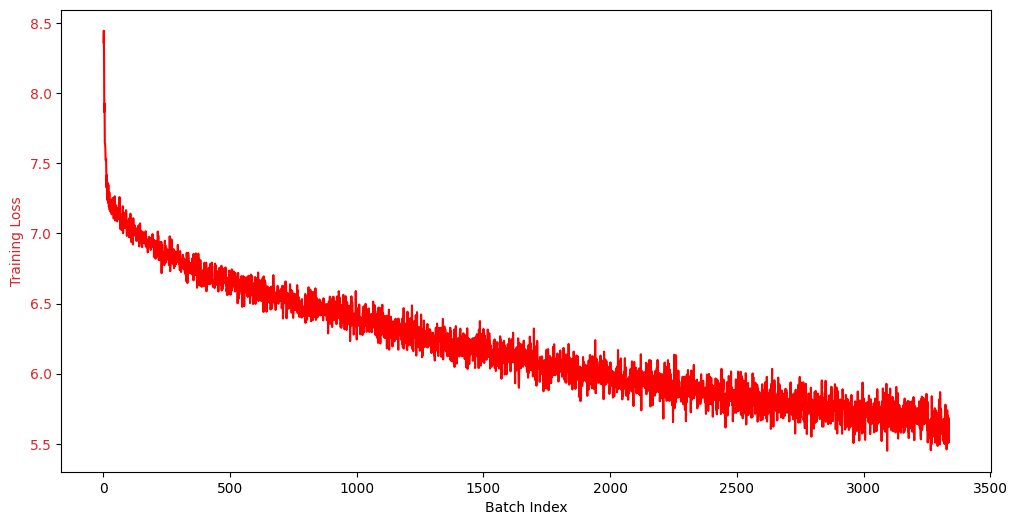

: 

In [7]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

# Initialize metrics
train_losses = []
#learning_rates = []

# Initialize the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a second y-axis sharing the same x-axis
#ax2 = ax1.twinx()

# Initialize x and y data arrays for losses and learning rates
x_data = []
y1_data = []
#y2_data = []

# Set the axis labels and title
ax1.set_xlabel("Batch Index")
ax1.set_ylabel("Training Loss", color="tab:red")
#ax2.set_ylabel("Learning Rate", color="tab:blue")

# Training Loop
for epoch_idx in range(num_epochs):
    model.train()
    for batch_idx, (train_images, train_labels) in enumerate(train_loader1k):
        train_images, train_labels = train_images.to(device), train_labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        train_outputs = model(train_images)

        # Compute the loss
        train_loss = criterion(train_outputs, train_labels)

        # Backward pass and optimization
        train_loss.backward()

        # Gradient Clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Step optimizer and the scheduler
        optimizer.step()
        #scheduler.step()


        # Store metrics
        train_losses.append(train_loss.item())  # Replace with your train_loss
        #learning_rates.append(scheduler.get_last_lr()[0])  # Replace with your scheduler
        
        # Append new data to the data arrays
        x_data.append(len(train_losses))
        y1_data.append(train_losses[-1])
        #y2_data.append(learning_rates[-1])
        
        # Clear previous figure
        ax1.clear()
        #ax2.clear()
        
        # Redraw the plot with updated data
        ax1.plot(x_data, y1_data, 'r')
        #ax2.plot(x_data, y2_data, 'b')
        
        ax1.set_xlabel("Batch Index")
        ax1.set_ylabel("Training Loss", color="tab:red")
        #ax2.set_ylabel("Learning Rate", color="tab:blue")
        
        ax1.tick_params(axis='y', labelcolor="tab:red")
        #ax2.tick_params(axis='y', labelcolor="tab:blue")
        #ax2.yaxis.set_label_coords(1.10,0.5)
        
        # Display the figure
        display(fig)
        
        # Clear notebook output
        clear_output(wait=True)
        
        #print(f"Epoch [{epoch_idx+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader1k)}], Loss: {train_loss.item():.4f}")

In [ ]:
# Save
torch.save(model, './models/vit-base-32p.pth')

In [ ]:
# Validation Loop
# NOTE: LOGITS TO MAX LOGIT FUNCTION MIGHT CHANGE DUE TO SPECIFIC NATURE OF VISION TRANSFORMER ALGORITHM

model.eval()
with torch.no_grad():

    correct_count = 0
    total_count = 0

    for val_images, val_labels in val_loader1k:
        val_images, val_labels = val_images.to(device), val_labels.to(device)

        # Logits
        val_outputs = model(val_images)

        # Let the index of the highest logit be the predicted class 
        _, val_predicted = torch.max(val_outputs.data, 1)

        # Update counts from this batch's values
        total_count += val_labels.size(0)
        correct_count += (val_predicted == val_labels).sum().item()

    # Print accuracy score
    print(f'Accuracy of the model on the validation images: {100 * correct_count / total_count}%')

NOTE: now that we fixed the hyperparameters and can see lr and loss live, lets go back to Adam optimizer and test diff schedulers!